In [1]:
import arviz
import pyro
import torch
import numpy as np
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
from torch.distributions import constraints
from scipy.stats import multivariate_normal

In [2]:
!mkdir images

mkdir: images: File exists


In [3]:
# The function
g = lambda x: (-(np.sin(6*torch.pi*x))**2) + 6*(x**2) - 5*(x**4) + (3/2)

In [4]:
# create dataset
SIZE = 30
X = torch.linspace(0, 1, SIZE)
y = g(X) + np.random.normal(scale = 0.01, size = (SIZE,))
choose = np.random.choice(SIZE, int(SIZE * 2/3), replace= False)
non_choosen = np.setdiff1d(np.arange(SIZE), choose)
X_train, X_test = X[choose], X[non_choosen]
y_train, y_test = y[choose], y[non_choosen]

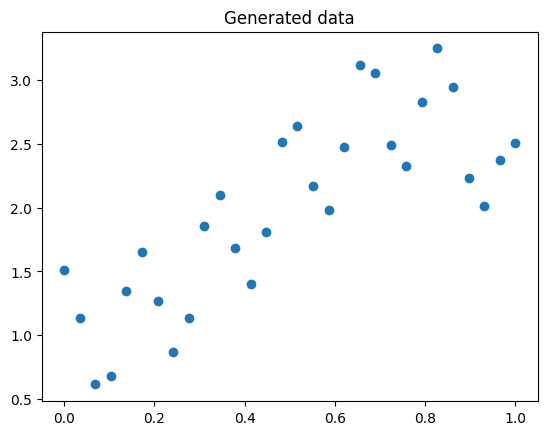

In [5]:
plt.scatter(X, y)
plt.title("Generated data")
plt.show()
plt.close()

Visually inspecting the dataset shows that there is a general upwards trend, and a periodicity around this trend. 

Thus, we have chosen sum an RBF kernel and a Periodic kernel, hoping that the first will model the overall trend, and the latter will capture the periodicity. We fix the variance at 1.0 for both kernels too allow faster training.

Inspired from https://pyro.ai/examples/gp.html
and https://pyro.ai/examples/mle_map.html

In [6]:
# function for creating the GPRegression object with priors

def gen_model(priors = True, period = torch.tensor(1.), lengthPer = torch.tensor(1.), 
              lengthRBF = torch.tensor(1.), varPer = torch.tensor(1.), varRBF= torch.tensor(1.)):
    
    # defining kernels
    periodic = gp.kernels.Periodic(input_dim=1, period=period, lengthscale=lengthPer, variance=varPer)
    rbf = gp.kernels.RBF(input_dim=1, lengthscale=lengthRBF, variance=varRBF)
    k = gp.kernels.Sum(kern0=rbf, kern1=periodic)

    model = gp.models.GPRegression(
        X=X_train,
        y=y_train,
        kernel=k,
        noise= torch.tensor(0.1),
    )
    if priors == True: 
        # RBF Kernel               
        model.kernel.kern0.variance_unconstrained.detach_()
        model.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.5))
        # Periodic Kernel
        model.kernel.kern1.variance_unconstrained.detach_()
        model.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1, 0.5))
        model.kernel.kern1.period = pyro.nn.PyroSample(dist.LogNormal(-1, 0.5))
            
    return model

In [7]:
# training the model to find MAP-estimates

def train_model(model, print_map = False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 2000 
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(model.model, model.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if print_map == True:
        model.set_mode("guide")
        # MAP
        # print(f"Linear, Variance: {model.kernel.kern0.variance.item()}\n")

        print(f"RBF, Variance: {model.kernel.kern0.variance.item()}")
        print(f"RBF, Lengthscale: {model.kernel.kern0.lengthscale.item()}\n")
        print(f"Periodic Kernel, Variance: {model.kernel.kern1.variance.item()}")
        print(f"Periodic Kernel, Lengthscale: {model.kernel.kern1.lengthscale.item()}\n")
        print(f"Periodic Kernel, Period: {model.kernel.kern1.period.item()}")
        print(f"Noise: {model.noise.item()}")
    
    return model

In [8]:
# plotting model predictions
def plot_model(model, X_train, X_test, y_train, y_test):
    plt.scatter(X_test, y_test, label = "Test data")
    plt.scatter(X_train, y_train, label = "Training data")
    x_space = np.linspace(0, 1, 300)
    y_space = g(x_space)
    plt.plot(x_space, y_space, label = "G(x)")
    with torch.no_grad():
        mean, var = model(X_test, noiseless = False) # a.k.a posterior predictive
    plt.plot(X_test, mean, color="C3", label = "Predictions")
    plt.scatter(X_test, mean, color = "C3", s = 2, )
    plt.fill_between(X_test, (mean + 1.95*var.sqrt()), (mean - 1.95*var.sqrt()), alpha = 0.1, color = "C0")
    plt.legend()


In [9]:
# calculate posterior likelihood on test data with trained model/MAP estimates
def MAP_likelihood(model, X_test, y_test):
    with torch.no_grad():
        mean, cov = model(X_test, full_cov = True, noiseless = False)
    return multivariate_normal.pdf(y_test, mean, cov)

In [10]:
# train GP model using MCMC to allow sampling from posterior for parameters
def MCMC(model, i = 0):
    nuts_kernel = pyro.infer.NUTS(model.model, jit_compile=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=250, num_chains=2, warmup_steps=100)
    mcmc.run()

    data = arviz.from_pyro(mcmc)
    summary = arviz.summary(data)
    print(summary)

    arviz.plot_posterior(data)
    plt.tight_layout()
    plt.savefig(f"./images/nuts_posterior_{i}.png")
    plt.close()
    arviz.plot_trace(data)
    plt.tight_layout()
    plt.savefig(f"./images/nuts_trace_{i}.png")
    plt.close()
    samples = mcmc.get_samples()

    return samples

# calculate posterior likelihood of test data using samples from posterior on parameters
def NUTS_likelihood(model, X_test, y_test, n_samples = 500, i = 0):
    samples = MCMC(model, i)
    plot_model(model, X_train, X_test, y_train, y_test)
    plt.tight_layout()
    plt.savefig("./images/nuts_predictions_" + str(i) + ".png")
    plt.close()
    posterior_predictive = []
    
    for i in range(n_samples):
        pyro.clear_param_store()
        fixed_model = gen_model(
            priors = False,
            lengthRBF=samples['kernel.kern0.lengthscale'][i], 
            lengthPer=samples['kernel.kern1.lengthscale'][i],
            period=samples["kernel.kern1.period"][i]
            )

        with torch.no_grad():
            mean, cov = fixed_model(X_test, full_cov=True, noiseless = False)
            posterior_predictive.append((mean, cov))
            
    likelihood = [multivariate_normal.pdf(y_test, mean, cov) for mean, cov in posterior_predictive]
    likelihood = torch.mean(torch.tensor(likelihood))
    
    return likelihood

In [11]:
map_likelihood_collection = []
nuts_likelihood_collection = []

for i in range(20):    
    # create dataset
    X = torch.linspace(0, 1, SIZE)
    y = g(X) + np.random.normal(scale = 0.01, size = (SIZE,))
    choose = np.random.choice(SIZE, int(SIZE * 2/3), replace= False)
    non_choosen = np.setdiff1d(np.arange(SIZE), choose)
    X_train, X_test = X[choose], X[non_choosen]
    y_train, y_test = y[choose], y[non_choosen]
    
    # train MAP model
    pyro.clear_param_store()
    model1 = gen_model()
    train_model(model1)
    plot_model(model1, X_train, X_test, y_train, y_test)
    plt.tight_layout()
    plt.savefig("./images/map_predictions_" + str(i) + ".png")
    plt.close()
    map_likelihood = MAP_likelihood(model1, X_test, y_test)
    
    #train NUTS model
    pyro.clear_param_store()
    model2 = gen_model()
    nuts_likelihood = NUTS_likelihood(model2, X_test, y_test, i = i)
    
    map_likelihood_collection.append(map_likelihood)
    nuts_likelihood_collection.append(nuts_likelihood.item())

Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.792  0.333   0.221    1.326      0.036    0.025   
kernel.kern1.lengthscale  0.622  0.266   0.263    1.102      0.048    0.034   
kernel.kern1.period       0.738  0.247   0.479    1.147      0.082    0.060   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      50.0      93.0   1.04  
kernel.kern1.lengthscale      40.0      67.0   1.07  
kernel.kern1.period            6.0     110.0   1.37  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.644  0.183   0.310    0.939      0.013    0.009   
kernel.kern1.lengthscale  0.812  0.232   0.439    1.284      0.088    0.065   
kernel.kern1.period       0.424  0.087   0.324    0.532      0.060    0.051   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     194.0     171.0   1.00  
kernel.kern1.lengthscale       7.0     130.0   1.25  
kernel.kern1.period            3.0      66.0   1.84  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.589  0.183   0.282    0.900      0.020    0.014   
kernel.kern1.lengthscale  0.690  0.399   0.142    1.301      0.241    0.192   
kernel.kern1.period       0.373  0.068   0.320    0.518      0.044    0.035   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      36.0     104.0   1.37  
kernel.kern1.lengthscale       3.0      10.0   1.88  
kernel.kern1.period            4.0      25.0   1.56  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.639  0.199   0.274    1.014      0.014    0.010   
kernel.kern1.lengthscale  0.944  0.286   0.521    1.539      0.018    0.013   
kernel.kern1.period       0.335  0.008   0.319    0.351      0.000    0.000   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     150.0      94.0   1.02  
kernel.kern1.lengthscale     262.0     235.0   1.00  
kernel.kern1.period          364.0     226.0   1.01  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.635  0.169   0.337    0.955      0.015    0.010   
kernel.kern1.lengthscale  0.950  0.362   0.269    1.449      0.028    0.020   
kernel.kern1.period       0.337  0.033   0.312    0.354      0.004    0.003   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     127.0     171.0   1.01  
kernel.kern1.lengthscale     177.0      99.0   1.02  
kernel.kern1.period          357.0     207.0   1.00  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.631  0.181   0.341    0.952      0.014    0.010   
kernel.kern1.lengthscale  0.974  0.466   0.189    1.777      0.051    0.036   
kernel.kern1.period       0.253  0.084   0.160    0.355      0.058    0.049   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     181.0     198.0   1.00  
kernel.kern1.lengthscale      65.0      55.0   1.08  
kernel.kern1.period            3.0      62.0   1.84  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.749  0.346   0.291    1.378      0.105    0.076   
kernel.kern1.lengthscale  0.726  0.331   0.213    1.309      0.155    0.118   
kernel.kern1.period       0.643  0.343   0.318    1.185      0.222    0.182   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      10.0     108.0   1.17  
kernel.kern1.lengthscale       5.0      59.0   1.41  
kernel.kern1.period            3.0      23.0   1.89  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.641  0.216   0.303    0.958      0.023    0.016   
kernel.kern1.lengthscale  0.811  0.275   0.313    1.308      0.117    0.088   
kernel.kern1.period       0.458  0.130   0.323    0.700      0.087    0.072   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     119.0     287.0   1.03  
kernel.kern1.lengthscale       6.0     166.0   1.28  
kernel.kern1.period            3.0      13.0   2.02  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.619  0.216   0.269    0.991      0.050    0.036   
kernel.kern1.lengthscale  0.861  0.292   0.509    1.593      0.116    0.086   
kernel.kern1.period       0.425  0.145   0.164    0.533      0.098    0.082   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      16.0      32.0   1.10  
kernel.kern1.lengthscale       6.0      23.0   1.24  
kernel.kern1.period            4.0      14.0   1.55  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.749  0.514   0.322    1.262      0.094    0.067   
kernel.kern1.lengthscale  0.602  0.168   0.290    0.899      0.049    0.035   
kernel.kern1.period       0.636  0.195   0.474    1.016      0.099    0.076   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      23.0     148.0   1.07  
kernel.kern1.lengthscale      12.0     165.0   1.14  
kernel.kern1.period            3.0      30.0   1.86  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.694  0.217   0.374    1.109      0.010    0.007   
kernel.kern1.lengthscale  0.987  0.266   0.542    1.478      0.013    0.010   
kernel.kern1.period       0.331  0.008   0.317    0.348      0.000    0.000   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     471.0     375.0    1.0  
kernel.kern1.lengthscale     369.0     196.0    1.0  
kernel.kern1.period          521.0     355.0    1.0  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.745  0.370   0.306    1.338      0.062    0.044   
kernel.kern1.lengthscale  0.846  0.258   0.401    1.333      0.051    0.038   
kernel.kern1.period       0.473  0.224   0.317    0.914      0.118    0.092   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      32.0      96.0   1.07  
kernel.kern1.lengthscale      27.0     131.0   1.08  
kernel.kern1.period            3.0      14.0   1.73  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.708  0.233   0.383    1.168      0.017    0.014   
kernel.kern1.lengthscale  0.527  0.106   0.343    0.737      0.006    0.004   
kernel.kern1.period       0.674  0.018   0.642    0.711      0.001    0.001   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     202.0     105.0   1.01  
kernel.kern1.lengthscale     317.0     208.0   1.01  
kernel.kern1.period          520.0     353.0   1.01  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.642  0.209   0.300    0.981      0.016    0.012   
kernel.kern1.lengthscale  0.701  0.182   0.397    0.997      0.015    0.012   
kernel.kern1.period       0.524  0.071   0.470    0.708      0.028    0.021   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     144.0     222.0   1.03  
kernel.kern1.lengthscale     157.0     143.0   1.02  
kernel.kern1.period           14.0      21.0   1.14  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.833  0.378   0.252    1.522      0.110    0.080   
kernel.kern1.lengthscale  0.915  0.344   0.335    1.554      0.036    0.026   
kernel.kern1.period       0.585  0.384   0.262    1.402      0.202    0.156   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      12.0     127.0   1.13  
kernel.kern1.lengthscale      56.0     139.0   1.05  
kernel.kern1.period            5.0      43.0   1.75  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.599  0.172   0.334    0.944      0.010    0.007   
kernel.kern1.lengthscale  0.758  0.278   0.326    1.271      0.106    0.079   
kernel.kern1.period       0.418  0.085   0.322    0.529      0.059    0.050   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     309.0     339.0   1.01  
kernel.kern1.lengthscale       8.0      31.0   1.19  
kernel.kern1.period            3.0      23.0   1.85  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.609  0.187   0.322    0.938      0.014    0.010   
kernel.kern1.lengthscale  0.683  0.152   0.404    0.956      0.011    0.008   
kernel.kern1.period       0.503  0.017   0.472    0.534      0.001    0.001   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     185.0     223.0    1.0  
kernel.kern1.lengthscale     193.0     213.0    1.0  
kernel.kern1.period          460.0     335.0    1.0  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.598  0.172   0.323    0.893      0.013    0.010   
kernel.kern1.lengthscale  0.731  0.235   0.362    1.201      0.050    0.036   
kernel.kern1.period       0.521  0.129   0.322    0.704      0.064    0.049   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     202.0     182.0   1.02  
kernel.kern1.lengthscale      18.0     120.0   1.09  
kernel.kern1.period            4.0      14.0   1.50  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.750  0.305   0.334    1.338      0.042    0.030   
kernel.kern1.lengthscale  0.566  0.179   0.261    0.822      0.024    0.019   
kernel.kern1.period       0.667  0.154   0.469    0.833      0.034    0.024   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      73.0      75.0   1.01  
kernel.kern1.lengthscale      87.0      51.0   1.05  
kernel.kern1.period           20.0      13.0   1.57  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.636  0.226   0.304    1.101      0.034    0.024   
kernel.kern1.lengthscale  0.720  0.263   0.325    1.232      0.142    0.110   
kernel.kern1.period       0.521  0.156   0.322    0.688      0.105    0.089   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      37.0      64.0   1.05  
kernel.kern1.lengthscale       3.0      77.0   1.60  
kernel.kern1.period            3.0      55.0   1.89  


In [12]:
map_likelihood_collection
print(f"Mean {np.mean(map_likelihood_collection):.3f}, SD {np.std(map_likelihood_collection):.3f}")

Mean 3484110369.499, SD 6265598968.615


In [13]:
nuts_likelihood_collection
print(f"Mean {np.mean(nuts_likelihood_collection):.3f}, SD {np.std(nuts_likelihood_collection):.3f}")

Mean 0.174, SD 0.075


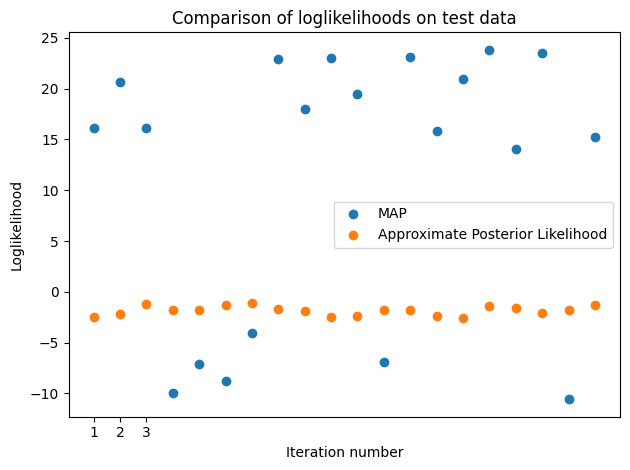

In [14]:
plt.scatter(range(1, 21), np.log(map_likelihood_collection), label = "MAP")
plt.scatter(range(1, 21), np.log(nuts_likelihood_collection), label = "Approximate Posterior Likelihood")
plt.ylabel("Loglikelihood")
plt.xlabel("Iteration number")
plt.xticks(range(1, 4))
plt.title("Comparison of loglikelihoods on test data")
plt.tight_layout()
plt.savefig("Likelihood_comparison.png")
plt.legend()
plt.show()